In [271]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [1]:
import math
import random
from PIL import Image as image
from collections import defaultdict
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%matplotlib inline

ops = {'go': 0, 'turn_left': 1, 'turn_right': 2}
cells = {'empty': 0, 'visited': 1}

def visited_surrounding(bitmap, x, y):
    num_visited = 0
    for delx in [-1, 0, 1]:
        for dely in [-1, 0, 1]:
            if bitmap[-(y+dely)][x+delx] == cells['visited']:
                num_visited += 1
    return num_visited

def try_generate_program(program_length, p_turn):
    bitmap = defaultdict(lambda: defaultdict(lambda: cells['empty']))
    program = []
    x = y = phi = 0
    bitmap[-y][x] = cells['visited']
    for i in xrange(program_length):
        if random.random() >= p_turn:
            op = ops['go']
            x += round(math.cos(phi))
            y += round(math.sin(phi))
            if bitmap[-y][x] != cells['empty']:
                return None
            else:
                bitmap[-y][x] = cells['visited']
            if visited_surrounding(bitmap, x, y) > 3:
                return None
        else:
            if random.random() < 0.5:
                op = ops['turn_left']
                phi += math.pi/2
                if len(program) > 0 and program[-1] == ops['turn_right']:
                    return None
            else:
                op = ops['turn_right']
                phi -= math.pi/2
                if len(program) > 0 and program[-1] == ops['turn_left']:
                    return None
        program.append(op)
    return program, bitmap

def generate_program(program_length, p_turn):
    for _ in xrange(1000):
        r = try_generate_program(program_length, p_turn)
        if r is not None:
            return r

def generate_programs(num_programs=1000, program_length=24, p_turn=0.3):
    lookup = set()
    width = height = program_length*2+1
    programs = np.zeros((num_programs, program_length, 3))
    bitmaps = np.zeros((num_programs, width * height))
    i = 0
    while i < num_programs:
        program, bitmap = generate_program(program_length, p_turn)
        program = tuple(program)
        if tuple(program) not in lookup:
            lookup.add(tuple(program))
            for k in xrange(program_length):
                programs[i, k, program[k]] = 1 # one-hot
            ai = 0
            for w in xrange(-program_length, program_length):
                for h in xrange(-program_length, program_length):
                    bitmaps[i, ai] = bitmap[w][h]
                    ai += 1    
            i += 1
            print(i, end='   \r')
    return programs, bitmaps

def to_program(program):
    inv_ops = {v: k for k, v in ops.iteritems()}
    rp = []
    for i in xrange(len(program)):
        for k in xrange(len(program[i])):
            if program[i][k] == 1:
                rp.append(inv_ops[k])
    return rp

def show_bitmap(bitmap, program_length):
    width = height = program_length*2+1
    data = np.zeros((width, height))
    ia = 0
    for w in xrange(-program_length, program_length):
        for h in xrange(-program_length, program_length):
            data[w+program_length, h+program_length] = bitmap[ia]
            ia += 1
    plt.axis('off')
    plt.imshow(data, cmap=plt.cm.gray, aspect='equal')
    
def get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training):
    batch_programs.fill(0)
    batch_bitmaps.fill(0)
    for i in xrange(batch_size):
        r = int(random.random() * len(programs) * p_training)
        batch_programs[i] = programs[r]
        batch_bitmaps[i] = bitmaps[r]

def get_test_batch(programs, bitmaps, test_programs, test_bitmaps, test_size, p_training):
    test_programs.fill(0)
    test_bitmaps.fill(0)
    offset = int(p_training * len(programs))
    for i in xrange(test_size):
        test_programs[i] = programs[offset+i]
        test_bitmaps[i] = bitmaps[offset+i]

['go', 'turn_right', 'go', 'turn_left', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go']


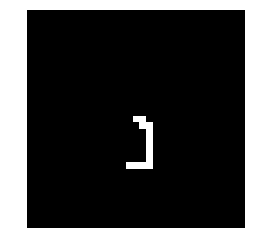

In [2]:
program_length=16
num_programs=1*1000
programs, bitmaps = generate_programs(num_programs, program_length, p_turn=0.3)
print(to_program(programs[0]))
show_bitmap(bitmaps[0], program_length)

In [225]:
width = height = program_length*2+1
x = tf.placeholder(tf.float32, [None, width*height])
# x is the input image as a long row vector
W = tf.Variable(tf.zeros([width*height, program_length * len(ops.keys())]))
# W are the weights, going from each input to output, where each output op is one-hot encoded
b = tf.Variable(tf.zeros([program_length * len(ops.keys())]))
# b are the biases for each output
#y = tf.nn.softmax(tf.reshape(tf.matmul(x, W) + b, [-1, program_length, len(ops.keys())]), dim=2)
y = tf.reshape(tf.matmul(x, W) + b, [-1, program_length, len(ops.keys())])
# y are the predicted program for each x, one-hot encoded, so it's shape is num_programs x program_length x num_ops
y_ = tf.placeholder(tf.float32, [None, program_length, len(ops.keys())])
# y_ is the correct one-hot encoded program, for computing cross-entropy
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])) # loss function is cross_entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
num_training_runs = 10*1000
batch_size = 100
p_training = 0.9
width = height = program_length*2+1
batch_programs = np.zeros((batch_size, program_length, 3))
batch_bitmaps = np.zeros((batch_size, width * height))
for i in range(num_training_runs):
    get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training)
    _, train_error, weights, bias = sess.run([train_step, cross_entropy, W, b], feed_dict={x: batch_bitmaps, y_: batch_programs})
    print((i, train_error), end='   \r')

np.set_printoptions(threshold=np.nan)
#print(weights)
print(bias)

#correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
#accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

test_size = int(len(programs) * (1.0 - p_training))
test_programs = np.zeros((test_size, program_length, 3))
test_bitmaps = np.zeros((test_size, width * height))
get_test_batch(programs, bitmaps, test_programs, test_bitmaps, test_size, p_training)

#print(sess.run(accuracy, feed_dict={x: test_bitmaps, y_: test_programs}))

actuals = sess.run(y_, feed_dict={x: test_bitmaps, y_: test_programs})
prediction_probas = sess.run(y, feed_dict={x: test_bitmaps, y_: test_programs})

predictions = np.zeros((len(prediction_probas), program_length, 3))
for i in xrange(len(prediction_probas)):
    for j in xrange(program_length):
        max_proba = 0
        which = 0
        for k in xrange(len(ops.keys())):
            if prediction_probas[i][j][k] > max_proba:
                which = k
                max_proba = prediction_probas[i][j][k]
        predictions[i][j][which] = 1

[-0.09241431  0.04535684  0.0470571   0.24307013 -0.12756351 -0.11550715
  0.28640246 -0.15375225 -0.13265088  0.38347337 -0.19360229 -0.18987121
  0.38519049 -0.19266117 -0.19253001  0.42073902 -0.23272651 -0.18801153
  0.42285046 -0.21470191 -0.20814875  0.40835086 -0.2152489  -0.19310181
  0.43474439 -0.21465695 -0.22008687  0.4161123  -0.19352558 -0.22258602
  0.4388842  -0.21811834 -0.22076477  0.39456907 -0.19517522 -0.19939367
  0.39978239 -0.21552373 -0.18425848  0.39627376 -0.19740278 -0.19887199
  0.38278812 -0.19669154 -0.18609641  0.35725912 -0.17978504 -0.17747438
  0.40071449 -0.18656458 -0.21415013  0.36325878 -0.18129012 -0.18196882
  0.34057429 -0.17317824 -0.16739714  0.33806407 -0.15571056 -0.18235296
  0.35332581 -0.21370396 -0.13962251  0.3322247  -0.1562347  -0.17598909
  0.31816316 -0.15749218 -0.16067149  0.2805447  -0.11835641 -0.16218784]


In [227]:
index = 568
print(to_program(actuals[index]))
print(to_program(predictions[index]))
print(actuals[index])
print(predictions[index])

['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'turn_right', 'go', 'go', 'go', 'go', 'turn_left', 'go', 'turn_left', 'turn_right', 'turn_right', 'turn_left', 'go', 'go', 'turn_left']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0

In [228]:
def num_go(li, program_length):
    num_go = 0
    for i in xrange(len(li)):
        for j in xrange(program_length):
            if li[i][j][0] == 1: num_go += 1
    return num_go
num_predictions_go = num_go(predictions, program_length)
num_actuals_go = num_go(actuals, program_length)
print(float(num_predictions_go) / (len(predictions) * program_length))
print(float(num_actuals_go) / (len(actuals) * program_length))

0.965382048715
0.725392058725


In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv = weight_variable([3, 3, 1, program_length * len(ops.keys())])
x_image = tf.reshape(x, [-1, width, height, 1])
h_conv = tf.nn.relu(conv2d(x_image, W_conv))
h_pool = max_pool_2x2(h_conv)
reduced_width = int(math.ceil(float(width)/2))
reduced_height = int(math.ceil(float(height)/2))
h_pool_reshaped = tf.reshape(h_pool, [-1, reduced_width * reduced_height * program_length * len(ops.keys())])
W = weight_variable([reduced_width * reduced_height * program_length * len(ops.keys()), program_length * len(ops.keys())])
b = bias_variable([program_length * len(ops.keys())])
h = tf.nn.relu(tf.matmul(h_pool_reshaped, W) + b)
y = tf.reshape(h, [-1, program_length, len(ops.keys())])
y_ = tf.placeholder(tf.float32, [None, program_length, len(ops.keys())])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
num_training_runs = 10*1000
batch_size = 100
p_training = 0.9
width = height = program_length*2+1
batch_programs = np.zeros((batch_size, program_length, 3))
batch_bitmaps = np.zeros((batch_size, width * height))
for i in range(num_training_runs):
    get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training)
    _, train_error = sess.run([train_step, cross_entropy], feed_dict={x: batch_bitmaps, y_: batch_programs})
    print((i, train_error), end='   \r')

In [207]:
actuals = sess.run(y_, feed_dict={x: test_bitmaps, y_: test_programs})
prediction_probas = sess.run(y, feed_dict={x: test_bitmaps, y_: test_programs})

predictions = np.zeros((len(prediction_probas), program_length, 3))
for i in xrange(len(prediction_probas)):
    for j in xrange(program_length):
        max_proba = 0
        which = 0
        for k in xrange(len(ops.keys())):
            if prediction_probas[i][j][k] > max_proba:
                which = k
                max_proba = prediction_probas[i][j][k]
        predictions[i][j][which] = 1

In [223]:
index = 49
print(to_program(actuals[index]))
print(to_program(predictions[index]))
print(actuals[index])
print(predictions[index])

['go', 'go', 'turn_right', 'turn_right', 'turn_left', 'turn_left', 'go', 'go', 'turn_left', 'go']
['go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go', 'go']
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]]
[[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]]


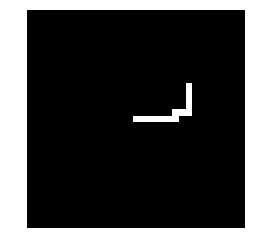

In [270]:
show_bitmap(bitmaps[6], program_length)

In [12]:
width = height = program_length*2+1
batch_size = 100
p_training = 0.9
state_size = width * height * 4
batch_programs = np.zeros((batch_size, program_length, 3))
batch_bitmaps = np.zeros((batch_size, width * height))

tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, width * height * program_length])
y_ = tf.placeholder(tf.int32, [None, program_length, len(ops.keys())])
init_state = tf.placeholder(tf.float32, [batch_size, state_size])
labels_series = tf.unstack(y_, axis=1)
inputs_series = tf.split(x, program_length, 1)
cell = tf.contrib.rnn.BasicRNNCell(state_size)
#cell = tf.contrib.rnn.LSTMCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

W = tf.Variable(np.random.rand(state_size, len(ops.keys())), dtype=tf.float32)
b = tf.Variable(np.zeros((1, len(ops.keys()))), dtype=tf.float32)
logits_series = [tf.matmul(state, W) + b for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]
losses = [tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series, labels_series)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(0.1).minimize(total_loss)

test_size = int(len(programs) * (1.0 - p_training))
test_programs = np.zeros((test_size, program_length, 3))
test_bitmaps = np.zeros((test_size, width * height))
get_test_batch(programs, bitmaps, test_programs, test_bitmaps, test_size, p_training)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch_idx in range(10):
        _current_state = np.zeros((batch_size, state_size))
        print("New data, epoch", epoch_idx)
        for batch_idx in range(100):
            get_training_batch(programs, bitmaps, batch_programs, batch_bitmaps, batch_size, p_training)
            repeated_batch_bitmaps = np.tile(batch_bitmaps, [1, program_length])
            _total_loss, _train_step, _current_state, _predictions_series = sess.run([total_loss, train_step, current_state, predictions_series], feed_dict={x: repeated_batch_bitmaps, y_: batch_programs, init_state:_current_state})
            print("Step", batch_idx, "Loss", _total_loss)
get_training_batch(test_programs, test_bitmaps, batch_programs, batch_bitmaps, batch_size, p_training=1.0)
repeated_batch_bitmaps = np.tile(batch_bitmaps, [1, program_length])
actuals, prediction_probas = sess.run([y_, predictions_series], feed_dict={x: repeated_batch_bitmaps, y_: batch_programs, init_state: _current_state})
predictions = np.zeros((len(prediction_probas), program_length, 3))
for i in xrange(len(prediction_probas)):
    for j in xrange(program_length):
        max_proba = 0
        which = 0
        for k in xrange(len(ops.keys())):
            if prediction_probas[i][j][k] > max_proba:
                which = k
                max_proba = prediction_probas[i][j][k]
        predictions[i][j][which] = 1
for index in xrange(10):
    print(to_program(actuals[index]))
    print(to_program(predictions[index]))

New data, epoch 0
Step 0 Loss 2.36417
Step 1 Loss 68.0244
Step 2 Loss 107.754
Step 3 Loss 108.806
Step 4 Loss 120.415
Step 5 Loss 91.2408
Step 6 Loss 82.8679
Step 7 Loss 74.0711
Step 8 Loss 67.9222
Step 9 Loss 65.5863
Step 10 Loss 41.7279
Step 11 Loss 70.4665
Step 12 Loss 37.9402
Step 13 Loss 70.103
Step 14 Loss 28.7639
Step 15 Loss 53.8991
Step 16 Loss 33.4404
Step 17 Loss 55.5575
Step 18 Loss 28.296
Step 19 Loss 51.9772
Step 20 Loss 24.7965
Step 21 Loss 51.1222
Step 22 Loss 20.8621
Step 23 Loss 66.1234
Step 24 Loss 20.1714
Step 25 Loss 78.5796
Step 26 Loss 13.5079
Step 27 Loss 51.576
Step 28 Loss 14.7861
Step 29 Loss 50.6275
Step 30 Loss 10.3732
Step 31 Loss 49.1898
Step 32 Loss 30.9288
Step 33 Loss 46.1534
Step 34 Loss 25.6362
Step 35 Loss 38.1543
Step 36 Loss 26.6174
Step 37 Loss 34.3045
Step 38 Loss 21.0567
Step 39 Loss 30.7294
Step 40 Loss 23.864
Step 41 Loss 29.4516
Step 42 Loss 23.4147
Step 43 Loss 27.1624
Step 44 Loss 23.5547
Step 45 Loss 26.8663
Step 46 Loss 22.0636
Step 47 L

Step 91 Loss 8.99711
Step 92 Loss 8.21081
Step 93 Loss 8.88872
Step 94 Loss 7.8309
Step 95 Loss 9.52736
Step 96 Loss 7.11444
Step 97 Loss 9.92685
Step 98 Loss 6.78097
Step 99 Loss 9.97854
New data, epoch 4
Step 0 Loss 6.82723
Step 1 Loss 5.93025
Step 2 Loss 10.3924
Step 3 Loss 6.03026
Step 4 Loss 9.69959
Step 5 Loss 6.53202
Step 6 Loss 8.95468
Step 7 Loss 7.11688
Step 8 Loss 8.4544
Step 9 Loss 7.75568
Step 10 Loss 7.8908
Step 11 Loss 7.69545
Step 12 Loss 7.71419
Step 13 Loss 7.41969
Step 14 Loss 7.25687
Step 15 Loss 6.72291
Step 16 Loss 7.40439
Step 17 Loss 7.30888
Step 18 Loss 7.96057
Step 19 Loss 7.4266
Step 20 Loss 7.12069
Step 21 Loss 7.69002
Step 22 Loss 7.00618
Step 23 Loss 8.15585
Step 24 Loss 5.60336
Step 25 Loss 8.21483
Step 26 Loss 5.39885
Step 27 Loss 9.01659
Step 28 Loss 4.85018
Step 29 Loss 8.56607
Step 30 Loss 4.6373
Step 31 Loss 10.1302
Step 32 Loss 3.94889
Step 33 Loss 9.88899
Step 34 Loss 4.05849
Step 35 Loss 9.05186
Step 36 Loss 4.07571
Step 37 Loss 9.58021
Step 38 Lo

Step 82 Loss 3.73403
Step 83 Loss 2.66325
Step 84 Loss 3.35176
Step 85 Loss 3.12094
Step 86 Loss 3.40521
Step 87 Loss 2.6562
Step 88 Loss 3.76412
Step 89 Loss 2.88325
Step 90 Loss 2.92286
Step 91 Loss 3.0799
Step 92 Loss 3.08934
Step 93 Loss 3.26037
Step 94 Loss 3.09054
Step 95 Loss 3.15735
Step 96 Loss 3.22266
Step 97 Loss 3.08807
Step 98 Loss 3.31393
Step 99 Loss 2.98092
New data, epoch 8
Step 0 Loss 4.23591
Step 1 Loss 1.92254
Step 2 Loss 1.70893
Step 3 Loss 1.61197
Step 4 Loss 1.73949
Step 5 Loss 1.63957
Step 6 Loss 1.69951
Step 7 Loss 1.66552
Step 8 Loss 1.66058
Step 9 Loss 1.735
Step 10 Loss 1.76033
Step 11 Loss 1.61241
Step 12 Loss 1.71116
Step 13 Loss 1.70205
Step 14 Loss 1.81303
Step 15 Loss 1.68399
Step 16 Loss 1.71657
Step 17 Loss 1.80757
Step 18 Loss 1.67288
Step 19 Loss 1.65134
Step 20 Loss 1.5153
Step 21 Loss 1.72925
Step 22 Loss 1.8355
Step 23 Loss 1.64846
Step 24 Loss 1.72844
Step 25 Loss 1.68411
Step 26 Loss 1.80094
Step 27 Loss 1.64231
Step 28 Loss 1.75458
Step 29 Los

RuntimeError: Attempted to use a closed Session.

In [313]:
batch_programs.shape

(100, 16, 3)

In [307]:
x

<tf.Tensor 'Placeholder:0' shape=(?, 17424) dtype=float32>

In [308]:
width * height * program_length

17424

In [8]:
inputs_series

[<tf.Tensor 'split:0' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:1' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:2' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:3' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:4' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:5' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:6' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:7' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:8' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:9' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:10' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:11' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:12' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:13' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:14' shape=(?, 1089) dtype=float32>,
 <tf.Tensor 'split:15' shape=(?, 1089) dtype=float32>]

In [321]:
labels_series

[<tf.Tensor 'unstack:0' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:1' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:2' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:3' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:4' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:5' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:6' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:7' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:8' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:9' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:10' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:11' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:12' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:13' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:14' shape=(?, 3) dtype=int32>,
 <tf.Tensor 'unstack:15' shape=(?, 3) dtype=int32>]